#### Scope:

This project aims to look into ways of characterizing a behavioural process with tools and parameters used in information theory.  
This can give more insight into the nature of the process and can in turn be used to create models trying to explain behaviour following similar processes.

title ideas:  
Accuracy and comparability of partial models and their evolution/combination for a Partially Observable Markov Decision Process  
Internal model approximation using partial observations of a Markov Decision Process  
An information-theoretical approach to internal models in a Partially Observable Markov Decision Process

#### Example of a coin flip:

To have an easy example for how to calculate and estimate the information theoretic measures, which we want to apply to a Markov process later on, we can try them out on a coin flip.
The general formula for Shannon entropy is as follows:
$$ H(X) = - \sum_{x_i \epsilon X} p(x_i) \log_2p(x_i). $$ 
The Shannon entropy of a coin flip can be simplified to the binary entropy formula, since there are only two possible outcomes:
$$ H(p) = - [p \log_2{p} + (1-p) \log_2(1-p)]. $$ 
One can also define the Shannon entropy for blocks of some length $L$, where each block is a sequence of $L$ consecutive observations of $s_i \epsilon S$ (cover1999elements):
$$ H(s^L) = -\sum_{s_i^L \epsilon S^L} P(s_i^L) \log_2P(s_i^L). $$ 
For a fair coin, the two possible observations each have a probability of $\frac{1}{2}$, meaning that sequences of length $L$ will all have probabilities of $(\frac{1}{2})^L$.
The total entropy of a measurement of length L then equals $$H(s^L) = - \sum_{s_i^L \epsilon S^L} \Bigg(\frac{1}{2}\Bigg)^L \log_2\Bigg(\frac{1}{2}\Bigg)^L = - 2^L \Bigg(\frac{1}{2}\Bigg)^L \log_2\Bigg(\frac{1}{2}\Bigg)^L =L$$, coming from the fact that there are allways $2^L$ different combinations one can achieve from observing a coin for $L$ consecutive flips. In further mentions, this entropy will be called block entropy, since it concernes the entropy of "blocks" of length L.
This implies that the entropy rate (asymptotic increase in entropy with increase in sequence length) is $$ h_{\mu} = \lim_{L \to \infty} \frac{H(s^L)}{L} = 1 $$ (also see https://wiki.santafe.edu/images/1/1d/ComplexityLecture1D.pdf, slide 8).  

With this, the excess entropy (difference between block entropy and asymptotic entropy) can be evaluated to $$E = \lim_{L \to \infty} (H(s^L) - h_{\mu}L) = \lim_{L \to \infty} (L-L) = 0$$ and finally the total transient information (cumulative difference between asymptotic entropy and $H(s^L)$) $$T = \sum_{L=0}^{\infty} E + h_{\mu}L - H(s^L) = \sum_{L=0}^{\infty} 0 = 0 .$$ 
(crutchfield2001synchronizing)
This means that in the case of a fair coin, there is no transient information for consecutive coin flips, an agent observing the system would instantly be synchronized and able to estimate the randomness of the system correctly.
This makes sense, since a coin flip is a binary system with distinct characteristics, implying instant synchronization.
It is important to note, that this assumes that the agent is able to estimate the entropy of the combinations perfectly.

But what about estimating the entropy of the coin flip itself, just by observing multiple consecutive ones?
A simple approach is to first estimate the probability $p$ of the binary outcome with the relative abundance $n_p$ in a given set of $L$ consecutive observations:
$$ \hat{p}_L = \frac{n_p}{L}. $$
This estimate can be plugged into the Shannon entropy formula, resulting in teh so called plug-in binary entropy estimator for a sequence of length L (conant1973estimation):

$$
\hat{H}_L(p) = H(\hat{p}_L) = -[\frac{n_p}{L} \log_2\frac{n_p}{L} + (1-\frac{n_p}{L}) \log_2(1-\frac{n_p}{L})],
$$
which converges to $H(p)$ for $L \to \infty$ (Law of large numbers).

Since this estimation is very different to calculating the block entropy $H(s^L)$, measures like excess entropy and transient information can not be reasonably defined in the same way.
For this estimation, "syncronization" as defined in (crutchfield2001synchronizing) would also be impossible, since the estimate only ever equals the true entropy in infinity.

#### Moving to a general binary system

We can also look at a more general version of a coin flip, the biased coin flip, which can be explained in terms of a general binary system.
We have two distinct outcomes, $1$ and $0$, which have probabilities $p$ and $1-p$.
This system can also be explained as a Markov process:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pygraphviz
import os
import pickle
#from network_viz_functions import create_lower_diGraph, create_upper_diGraph
#os.environ["R_HOME"] = "C:\\Users\\alexa\\anaconda3\\envs\\PS\\Lib\\R"
#import rpy2.robjects as ro
#%load_ext rpy2.ipython

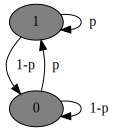

In [2]:
binary_graph = nx.MultiDiGraph()
binary_graph.add_nodes_from([("1", {"fillcolor": "grey", "subset":0}), ("0", {"fillcolor": "grey", "subset":0})])
edges = [("1", "0", "1-p"),
         ("0", "1", "p"),
         ("1", "1", "p"),
         ("0", "0", "1-p")]
binary_graph.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "   ") for edge in binary_graph.edges(data = True, keys = True)}
nx.set_edge_attributes(binary_graph, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(binary_graph)
D.node_attr.update(style = "filled")
D.layout('dot')

D

This process can now be written in terms of a transition matrix $P$:
$P = \begin{bmatrix} p & 1-p \\ p & 1-p \end{bmatrix}$

We now want to again calculate the same values we did for the fair coin.
Since the Markov process of this binary system is stationary (probabilities do not change over time), the entropy rate is given by the expression (cover1999elements):
$$ h_\mu = - \sum_{ij} \mu_i P_{ij} \log P_{ij}, $$
with $\mu$ being the stationary distribution of the transition matrix $P$.
The stationary distribution $\mu$ is defined as the distribution of state probabilities, to which the system described by $P$ converges in the limit of infinity. In other words, it also means that the stationary distribution does not change anymore when applying the transition matrix to it: $\mu P = \mu$.

Ways to compute $\mu$ are either to look at $\lim_{n \to \infty} P^n$, or to solve $\mu P = \mu$, an eigenvector problem.
One property of the stationary distribution is that it does not depend on the initial state of the system, meaning that $\lim_{n \to \infty} P^n$ should result in a matrix with identical rows, each row being $\mu$.  

From this, we can conclude that $P$ is already in the stationary limit for our case of the binary system, with $\mu$ being $[p, 1-p]$.
We can now calculate the entropy rate to be 
$$ h_\mu = -[p*(p \log p + (1-p) \log (1-p)) + (1-p)*(p \log p + (1-p) \log (1-p))] = $$ 
$$ = -[p \log p + (1-p) \log (1-p)] = H(p). $$

This implies that the entropy of a sequence from a binary system $H(s^L)$ is $L H(p)$, since $ h_\mu = \lim_{L \to \infty} \frac{H(s^L)}{L} $.
This means, that the excess entropy $E$ and transient information $T$ again evaluate to 0 in this case.

In [3]:
#defined functions

import numpy as np
import scipy as sp
# calculates the plug in entropy estimate for the elements of a given input sequence
def plugin_entropy(s):
    
    # calculate frequency of each unique sample value in order of appearance
    ucount = np.unique(s, return_counts = True)[1]
    # calculate entropy
    H = sp.stats.entropy(ucount, base = 2)

    return(H)


import sympy as sym
# calculates the stationary distribution of a Markov Process using its transition matrix P
def MP_stat_dist(P): 

    # make symbolic if not already the case
    P = sym.Matrix(P)
    # take eigenvector with eigenvalue 1
    eigenvectors = P.T.eigenvects()
    eigenvector = [eig for eig in eigenvectors if eig[0]==1]
    stationary_dist = eigenvector[0][2][0]
    # normalize to probability vector
    stationary_dist = (stationary_dist/sum(stationary_dist)).T 

    return(sym.simplify(stationary_dist))


import sympy as sym
import numpy as np
# calculates the entropy rate of a stationary Markov Process (Cover&Thomas)
def MP_entropy_rate(stat, P):

    # make inputs symbolic if not already
    stat_sym = sym.Matrix(stat)
    P_sym = sym.Matrix(P)
    # calculate entropy rate
    P_log = sym.matrix_multiply_elementwise(P_sym, P_sym.applyfunc(lambda x: sym.log(x, 2)))
    h = sym.simplify(-np.sum(P_log.T * stat_sym.T))

    return(h.evalf())


import sympy as sym
import numpy as np
import itertools
# calculates block entropy of length block_length for MP with transition matrix P
def MP_block_entropy(P, block_length, init_prob):

    # get possible combinations of length = block_length
    P_size = np.shape(P)[0]
    blocks = list(itertools.product(range(P_size), repeat = block_length))

    # calculate probability for each possible block
    prob_blocks = list()
    for block in blocks:
        prob_block = 1
        for l in range(block_length):
            if l == 0:
                prob_block *= init_prob[block[l]]
            else:
                prob_block *= P[block[l-1], block[l]]
        prob_blocks.append(prob_block)

    # renormalize probabilities if impossible combinations were present (p=0)
    if 0 in prob_blocks: prob_blocks = list(filter(lambda p_b: p_b != 0, prob_blocks))
    prob_blocks = [p_b / np.sum(prob_blocks) for p_b in prob_blocks]

    # calculate entropy
    H = 0
    for p in prob_blocks:
        H -= p*sym.log(p, 2)
        
    return(H.evalf())

#### Observing the delayed action MDP

The problem, which will be looked at in more detail, is a so-called "delayed action" experiment. One can picture an agent in a box, with a light switch, the light itself and a hatch through which a reward is given.
This setup can be described with the following Markov Decision Process (MDP), where $P_{ai}, P_{wi}, i = {0, 1, 2}$ denote the agent's policy to act or wait in a given state and $p_X$ is the base probability for the light to turn on when currently switched off.

#### MDP

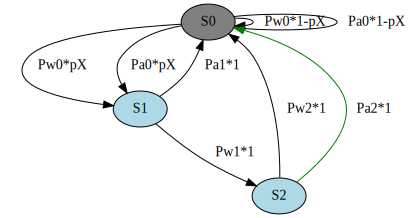

In [4]:
da_graph = nx.MultiDiGraph()
da_graph.add_nodes_from([("S0", {"fillcolor": "grey", "subset":0}), ("S1", {"fillcolor": "lightblue", "subset":0}), ("S2", {"fillcolor": "lightblue", "subset":0})])
edges = [("S0", "S1", "Pw0", {"p":"pX"}),
         ("S0", "S0", "Pw0", {"p":"1-pX"}),
         ("S0", "S1", "Pa0", {"p":"pX"}),
         ("S0", "S0", "Pa0", {"p":"1-pX"}),
         ("S1", "S2", "Pw1", {"p":1}),
         ("S1", "S0", "Pa1", {"p":1}),
         ("S2", "S0", "Pw2", {"p":1}),
         ("S2", "S0", "Pa2", {"p":1, "color": "green"})]
da_graph.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph)
D.node_attr.update(style = "filled")
D.layout('dot')

D

The agent now moves through the states according to its policy, but what is the result of this?
The state transition matrix for this MDP has the following form:
$$
\begin{matrix} S_0 & S_1 & S_2 \end{matrix} \\
\begin{matrix} S_0 \\  S_1  \\  S_2 \end{matrix}
\begin{bmatrix} 1 - p_X & p_X & 0 \\ \pi_{a1} & 0 & 1 - \pi_{a1} \\ 1 & 0 & 0 \end{bmatrix} = P.
$$
The n-step transition probability, so ending up in a specific state given the initial state, can be calculated with $P^n$, where after $P_{ij}^n$ denotes the probability to end up in state $j$ after $n$ steps, given that the initial state was $i$.
Naturally, the question of probabilities for the states in the limit of infinity arises, which is called the stationary distribution of a Markov Process.
For any ergodic Markov Process, there exists a stationary distribution $\pi$ such that $\pi P = \pi$, meaning that the state probabilities do not change anymore for any additional transitions.  

This is just a special kind of eigenvector problem, where the desired eigenvector has the eigenvalue 1 and has only positive elements, which sum to 1.
This means that it can be found using normal methods of linear algebra.
The stationary distribution can also be found by raising the transition matrix to a large enough power, so that the numerical values converge to $\pi$.
This final transition matrix in the limit would have $\pi$ for each of its rows, also meaning that the stationary distribution is independent of the initial state of the system.

In [5]:
import numpy as np
import sympy as sym

x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")

P_mdp = sym.Matrix([[1-x, x, 0],[a1, 0, 1-a1], [1, 0, 0]]) 
stat_mdp = MP_stat_dist(P_mdp)
stat_mdp_l = sym.lambdify([x, a1], stat_mdp) # lambdify for later evaluation
stat_mdp

Matrix([[1/(-\pi_{a1}*p_X + 2*p_X + 1), p_X/(-\pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a1} - 1)/(\pi_{a1}*p_X - 2*p_X - 1)]])

This means that the limiting state probabilities are as follows:
$$
P_{S_0} = \frac{1}{1 + p_X(2-\pi_{a1})}, P_{S_1} = \frac{p_X}{1 + p_X(2-\pi_{a1})}, P_{S_2} = \frac{p_X(1-\pi_{a1})}{1 + p_X(2-\pi_{a1})}
$$

If there is an observer, who can only observe the state of the light itself, so on or off, this observer will see a two state Markov Process (MP) with the following transition probabilities.

#### MP1

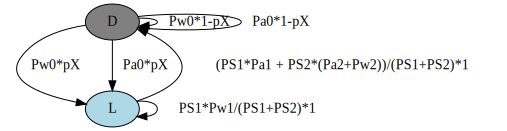

In [6]:
da_graph_light = nx.MultiDiGraph()
da_graph_light.add_nodes_from([("D", {"fillcolor": "grey", "subset":0}), ("L", {"fillcolor": "lightblue", "subset":0})])
edges = [("D", "L", "Pw0", {"p":"pX"}),
         ("D", "D", "Pw0", {"p":"1-pX"}),
         ("D", "L", "Pa0", {"p":"pX"}),
         ("D", "D", "Pa0", {"p":"1-pX"}),
         ("L", "D", "(PS1*Pa1 + PS2*(Pa2+Pw2))/(PS1+PS2)", {"p":1}),
         ("L", "L", "PS1*Pw1/(PS1+PS2)", {"p":1})]
da_graph_light.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_light.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_light, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_light)
D.node_attr.update(style = "filled")
D.layout('dot')

D

One can now calculate the probability to observe a light- or dark-state using the limiting state probabilities from above:
$$
P_D = P_{S0} = \frac{1}{1 + p_X(2-\pi_{a1})}, P_L = P_{S1}+P_{S2} = \frac{p_X(2-\pi_{a1})}{1 + p_X(2-\pi_{a1})}
$$

In [7]:
import sympy as sym

x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")

P_mp1 = sym.Matrix([[1-x, x], [1/(2-a1), (1-a1)/(2-a1)]])
stat_mp1 = MP_stat_dist(P_mp1)
stat_mp1_l = sym.lambdify([x, a1], stat_mp1) # lambdify for later evaluation
stat_mp1

Matrix([[1/(-\pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a1} - 2)/(\pi_{a1}*p_X - 2*p_X - 1)]])

Only looking at the actions of the agent also results in a two state MP, with rather trivial transition probabilities:
$$
P_A = P_{S_0}\pi_{a0} + P_{S_1}\pi_{a1} + P_{S_2}\pi_{a2} = \frac{\pi_{a0} + p_X\pi_{a1} + p_X(1-\pi_{a1})\pi_{a2}}{1 + p_X(2-\pi_{a1})}, P_W = 1- P_A
$$

In [8]:
import sympy as sym

x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")

pa = stat_mdp[0]*a0 + stat_mdp[1]*a1 + stat_mdp[2]*a2
P_mp2 = sym.Matrix([[pa, 1-pa], [pa, 1-pa]])

# P_mp2 is already stationary
stat_mp2 = sym.Matrix([[sym.simplify(pa), sym.simplify(1-pa)]])
stat_mp2_l = sym.lambdify([x, a0, a1, a2], stat_mp2) # lambdify for later evaluation
stat_mp2

Matrix([[(\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1))/(-\pi_{a1}*p_X + 2*p_X + 1), (-\pi_{a0} - 2*\pi_{a1}*p_X + \pi_{a2}*p_X*(\pi_{a1} - 1) + 2*p_X + 1)/(-\pi_{a1}*p_X + 2*p_X + 1)]])

#### MP2

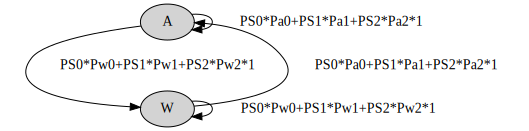

In [9]:
da_graph_action = nx.MultiDiGraph()
da_graph_action.add_nodes_from([("A", {"subset":0}), ("W", {"subset":0})])
edges = [("A", "A", "PS0*Pa0+PS1*Pa1+PS2*Pa2", {"p":1}),
         ("A", "W", "PS0*Pw0+PS1*Pw1+PS2*Pw2", {"p":1}),
         ("W", "A", "PS0*Pa0+PS1*Pa1+PS2*Pa2", {"p":1}),
         ("W", "W", "PS0*Pw0+PS1*Pw1+PS2*Pw2", {"p":1})]
da_graph_action.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_action.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_action, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_action)
D.node_attr.update(style = "filled")
D.layout('dot')

D

One can now also think about combining the two observations, so for example the observer always gets the information about the current state of the light and the action of the agent that brought it to that state.
This will now result in a MP with four states.

#### MP3

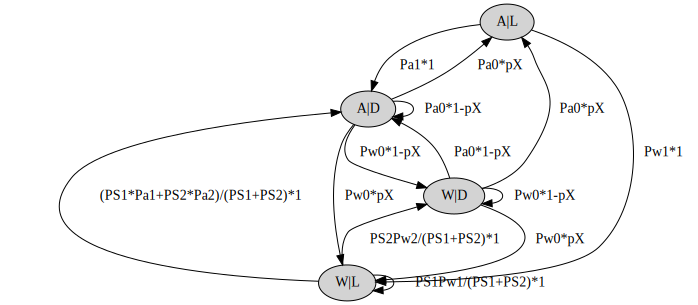

In [10]:
da_graph_combined = nx.MultiDiGraph()
da_graph_combined.add_nodes_from([("A|L", {"subset":0}), ("A|D", {"subset":0}), ("W|L", {"subset":0}), ("W|D", {"subset":0})])
edges = [#("A|L", "A|L", "0", {"p":1}),
         ("A|L", "A|D", "Pa1", {"p":1}),
         ("A|L", "W|L", "Pw1", {"p":1}),
         #("A|L", "W|D", "0", {"p":1}),
         ("A|D", "A|L", "Pa0", {"p":"pX"}),
         ("A|D", "A|D", "Pa0", {"p":"1-pX"}),
         ("A|D", "W|L", "Pw0", {"p":"pX"}),
         ("A|D", "W|D", "Pw0", {"p":"1-pX"}),
         #("W|L", "A|L", "0", {"p":1}),
         ("W|L", "A|D", "(PS1*Pa1+PS2*Pa2)/(PS1+PS2)", {"p":1}),
         ("W|L", "W|L", "PS1Pw1/(PS1+PS2)", {"p":1}),
         ("W|L", "W|D", "PS2Pw2/(PS1+PS2)", {"p":1}),
         ("W|D", "A|L", "Pa0", {"p":"pX"}),
         ("W|D", "A|D", "Pa0", {"p":"1-pX"}),
         ("W|D", "W|L", "Pw0", {"p":"pX"}),
         ("W|D", "W|D", "Pw0", {"p":"1-pX"})]
da_graph_combined.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_combined.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_combined, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_combined)
D.node_attr.update(style = "filled")
D.layout('dot')

D

In [11]:
import sympy as sym

x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")


ps1 = x / (1+x*(2-a1))
ps2 = x*(1-a1) / (1+x*(2-a1))
# A|L, A|D, W|L, W|D
P = sym.Matrix([[0, a1, 1-a1, 0],
    [a0*x, a0*(1-x), (1-a0)*x, (1-a0)*(1-x)],
    [0, (ps1*a1+ps2*a2)/(ps1+ps2), ps1*(1-a1)/(ps1+ps2), ps2*(1-a2)/(ps1+ps2)],
    [a0*x, a0*(1-x), (1-a0)*x, (1-a0)*(1-x)]])
P = sym.simplify(P)
MP_stat_dist(P)

Matrix([[\pi_{a0}*p_X/(\pi_{a0}*\pi_{a1}**2*p_X - 2*\pi_{a0}*\pi_{a1}*p_X + \pi_{a0}*p_X - \pi_{a1}*p_X + 2*p_X + 1), (\pi_{a0}*\pi_{a1}**2*\pi_{a2}*p_X - \pi_{a0}*\pi_{a1}**2*p_X - \pi_{a0}*\pi_{a1}*\pi_{a2}*p_X + \pi_{a0}*\pi_{a1}*p_X - \pi_{a0}*p_X + \pi_{a0} - \pi_{a1}*\pi_{a2}*p_X + \pi_{a1}*p_X + \pi_{a2}*p_X)/(\pi_{a0}*\pi_{a1}**2*p_X - 2*\pi_{a0}*\pi_{a1}*p_X + \pi_{a0}*p_X - \pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a0}*\pi_{a1}**2 - 2*\pi_{a0}*\pi_{a1} - \pi_{a1} + 2)/(\pi_{a0}*\pi_{a1}**2*p_X - 2*\pi_{a0}*\pi_{a1}*p_X + \pi_{a0}*p_X - \pi_{a1}*p_X + 2*p_X + 1), (-\pi_{a0}*\pi_{a1}**2*\pi_{a2}*p_X + \pi_{a0}*\pi_{a1}**2*p_X + \pi_{a0}*\pi_{a1}*\pi_{a2}*p_X - \pi_{a0}*\pi_{a1}*p_X + \pi_{a0}*p_X - \pi_{a0} + \pi_{a1}*\pi_{a2}*p_X - \pi_{a1}*p_X - \pi_{a2}*p_X + 1)/(\pi_{a0}*\pi_{a1}**2*p_X - 2*\pi_{a0}*\pi_{a1}*p_X + \pi_{a0}*p_X - \pi_{a1}*p_X + 2*p_X + 1)]])

The simplified probabilities for each state are then as follows (from Mathematica):
$$
P_{A|L} = \frac{p_X\pi_{a0}}{1+p_X(2+\pi_{a0}(\pi_{a1}-1)^2-\pi_{a1})}, 
$$
$$
P_{W|L} = \frac{p_X(\pi_{a1}-2)(\pi_{a0}\pi_{a1}-1)}{1+p_X(2+\pi_{a0}(\pi_{a1}-1)^2-\pi_{a1})}, 
$$
$$
P_{A|D} = \frac{p_X[\pi_{a0}[\pi_{a1}(\pi_{a1}-1)(\pi_{a2}-1)-1]+\pi_{a2}(1-\pi_{a1})+\pi_{a1}]+\pi_{a0}}{1+p_X(2+\pi_{a0} (\pi_{a1}-1)^2-\pi_{a1})}, 
$$
$$
P_{W|D} = \frac{p_X[\pi_{a1}(\pi_{a2}-1)-\pi_{a2}]+\pi_{a0}[p_X[\pi_{a1}(\pi_{a2}(1-\pi_{a1})+\pi_{a1}-1)+1]-1]+1}{1+p_X(2+\pi_{a0} (\pi_{a1}-1)^2-\pi_{a1})}
$$

Naively, one might for example think, that the probability to get the state $A|L$ would be the probability to be in $S_0$, then act, and the light turning on, so $P_{S_0}\pi_{a0}p_X$. 
$P_{A|L}$ differs from that result by a quadratic expression. (wrong conditional probability?)

How do those models obtained from observing parts of the system now represent the whole system, or how do they differ?

One can for example look at the block entropies each model generates and check how they differ from the entropy of the real system.
Since the systems all tend towards their respective stationary distributions, it suffices to look at their differences in entropy rate:

Plot showing difference between entropy rates of MDP and MP1, when varying the dependent probabilities (shows comparability in special scenarios).

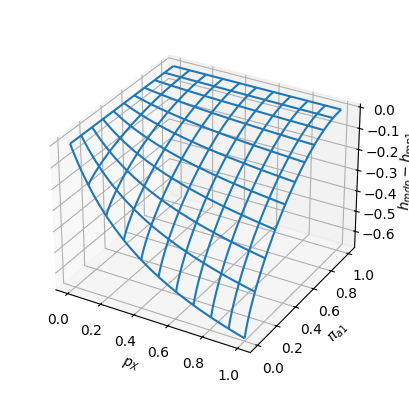

In [12]:
# differences in entropy rate
x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")
h_diff_mdpmp1 = sym.simplify(MP_entropy_rate(stat_mdp, P_mdp) - MP_entropy_rate(stat_mp1, P_mp1))
h_diff_mdpmp1_l = sym.lambdify([x, a1], h_diff_mdpmp1, "numpy")
#print("MDP-MP2: ", sym.simplify(MP_entropy_rate(stat_mdp, P_mdp) - MP_entropy_rate(stat_mp2, P_mp2)))

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection='3d')
valrange = np.linspace(0+1e-16, 1-1e-16, 100)
vx, va1 = np.meshgrid(valrange, valrange)
#print(h_diff_mdpmp1_l(vx, va1), type(h_diff_mdpmp1_l(vx, va1)))
hdiff_res = h_diff_mdpmp1_l(vx, va1)
ax.plot_wireframe(vx, va1, hdiff_res, rcount=10, ccount=10)
ax.set_xlabel("$p_X$")
ax.set_ylabel("$\pi_{a1}$")
ax.set_zlabel("$h_{mdp} - h_{mp1}$")
ax.set_box_aspect(None, zoom=0.9)

Plot showing the block entropies and estimates/calculations of the entropy rates for [x, a0, a1, a2] = [0.60, 0.5, 0.45, 0.5]

mdp
stat | disc
0.811717754843188 | 0.811843210251305
[1.58496250072116, 2.23953751686865, 3.03684527424659, 3.90906613133851, 4.68923732399599, 5.49991699240852, 6.32266796463139, 7.12810835756889, 7.93995156782020]
mp1
stat | disc
0.955224804161522 | 0.955224835665234
[1.00000000000000, 1.95463297334404, 2.91000287151243, 3.86519210424001, 4.82042562914017, 5.77564829531415, 6.73087362362747, 7.68609829928724, 8.64132313495248]
mp2
stat | disc
0.999302727715816 | 0.999302727715792
[1.00000000000000, 1.99930272771582, 2.99860545543163, 3.99790818314745, 4.99721091086326, 5.99651363857908, 6.99581636629490, 7.99511909401069, 8.99442182172648]


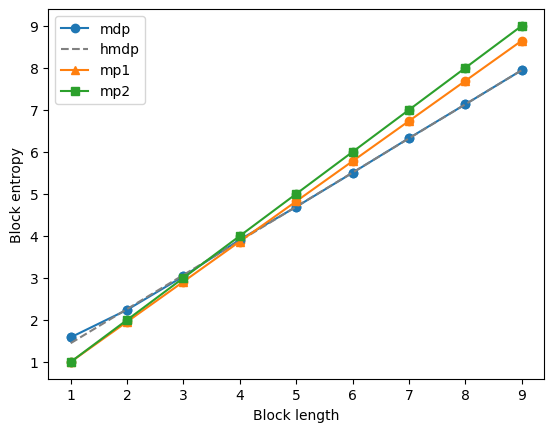

In [14]:
import numpy as np
import sympy as sym
import scipy as sp
import itertools
import matplotlib.pyplot as plt

vects = [stat_mdp, stat_mp1, stat_mp2]
labels = ["mdp", "mp1", "mp2"]
markers = ["o", "^", "s"]
Ps = [P_mdp, P_mp1, P_mp2]

for n, vect in enumerate(vects):
    P_s = Ps[n]
    vars = [x, a0, a1, a2]
    vals = [0.60, 0.5, 0.45, 0.5]
    inits = [[1/3, 1/3, 1/3], [1/2, 1/2], [1/2, 1/2]]

    vect = vect.subs({vars[i]:vals[i] for i in range(len(vars))})
    P_s = P_s.subs({vars[i]:vals[i] for i in range(len(vars))})

    lengths = range(1, 10)

    ent_rate = MP_entropy_rate(vect, P_s)
    block_ents = [MP_block_entropy(P_s, l, inits[n]) for l in lengths]

    print(labels[n])
    print("stat | disc")
    print(ent_rate, "|", block_ents[-1] - block_ents[-2])
    print(block_ents)

    plt.plot(lengths, block_ents, marker = markers[n], label = labels[n])
    if n == 0:
        plt.plot(np.arange(1,10), ent_rate*np.arange(1,10)+(block_ents[-1]-ent_rate*9), color = "grey", ls = "--", label = "hmdp")
    plt.scatter(lengths, block_ents)
# plot entropy rate slope for mdp
hmdp = float(MP_entropy_rate(vect, P_s))


plt.xlabel("Block length")
plt.ylabel("Block entropy")
plt.legend()
plt.show()

Explanation of block entropy plot above:
For MDP, MP1 and MP2, the respective entropy rates were calculated analytically (stat) using $ h_\mu = - \sum_{ij} \mu_i P_{ij} \log P_{ij} $ (coverthomas1999elements).
The numerical estimation of the entropy rates was done using block entropies. For this, the probability of any possible block or sequence of length $L$ was calculated by taking the initial probability of the first state of the sequence, here set to be 1/(number of states) (so equal initial probability), and multiplying the transition probability to the next state of the sequence iteratively. This is important, since the given MDP for example is directional. This also means that some invalid sequences, for example S0-S2-S1, result in probability 0, which is why at the end, the probability of all valid sequences has to be renormalized before calculating the entropy of those sequence probabilities.
The numerical entropy rate estimate (disc) was taken to be the difference between the block entropies of the two largest computed sequence lengths. 

One can see, that the entropy rates of MP1 and MP2 are very different from MDP.
Actually computing the correct block entropy for a given length gives an even more surprising result (mdp in plot, hmdp is with entropy rate). 
One can see that the estimated excess entropy of MDP is negative, implying that the system is less random at the beginning.
This is also supported by the fact, that the discrete entropy rate estimate of MDP is below the analytical result.
This is in contrast to the theory in (crutchfield2001synchronizing), where the entropy rate is overestimated for small sequence lengths (tangent of H(L)).
For interpretation, one might say that MDP seems less random at the beginning and increases in randomness with longer sequence lengths.

<img src="crutchfield_block_ent_fig.png" width="400">  

Figure from (crutchfield2001synchronizing), showing the block entropy, here H(L), behaviour for a periodic process.

An interesting special case:  
Since the transition matrix of the MDP does not allow permutations of the light states, the observed block entropy of MP1 would actually be identical to that of MDP, if and only if the starting state is S0.  
L = 2, S0:  S0-S1, S0-S0
            D-L, D-D  
L = 3, S0:  S0-S0-S0, S0-S0-S1, S0-S1-S0, S0-S1-S2
            D-D-D, D-D-L, D-L-D, D-L-L  
L = 4, S0:  S0-S0-S0-S0, S0-S0-S0-S1, S0-S0-S1-S0, S0-S0-S1-S2, S0-S1-S2-S0
            D-D-D-D, D-D-D-L, D-D-L-D, D-D-L-L, D-L-L-D

The reason for the mismatch is that in the observed systems of MP1 and MP2, the states of S1 and S2 are not generally separated (holevo2019quantum). Since S1 and S2 are both light states, MP1 can not distinguish between them. This means that MP1 can not accurately describe MDP as a statistical model.
MP2 by itself has even less separation between the states of MDP.
Any combination of the two, be it for several observations and so on, will always have states that result from two or more distinct states in MDP, which can not be distinguished by the created model.


Trying to formulate a more concrete reason for this case:  
Since for both S1 and S2 of MDP, the decision to wait leads to the same outcome, such a sequence starting in either S1 or S2 can not be distinguished and will thus be seen as one sequence, even though it originated in two different states. This leads to wrong state/sequence probabilities when compared to MDP.  
Also, when starting in the dark state, the system is synchronized, when starting in a light state, there are paths which can never synchronize.    

How wrong are they though?
Idea:  
create new model using sequences as states, contribution of superimposed states decreases with number of states,  
would have to try predictions of block entropy for L+1 using combinations of probabilities of L, since block-state models would have multiple versions of MDP states due to different paths.  

Possible to just use difference in entropy rate estimate from observations of different length?  
Rather use mismatch in state distribution and estimate using estimated transition matrix? (estimators in ciuperca2007estimation)

In contrast, POMDP solution approaches usually assume that the agent has the correct model, just not complete information about the current state (kaelbling1998pomdp).  
Maybe look into other measures instead of entropy, i.e. transfer entropy, mutual information (kim2021infstructures). (Paper from CAS lecture)

If an additional observation was also the given reward, it would be possible to separate the system just by observing the light and reward.
Also, the observations would actually be sufficient to determine, that the system is not binary, just by observing the light for a length of steps and comparing it to a prediction created by observations of shorter length.

#### Confidence in distinguishing entropies

How accurately can we say, that the entropy of two samples is not identical, given samples of same length L?
For example, one can ask how many samples would be needed to be able to say, that two entropy estimates differ from each other by two $\sigma$ (~95% conf.).

For this, we need to know the error of the entropy estimator.

In general, every estimator has two potential sources of error: estimator bias and variance.
The entropy plug-in estimator $\hat{H}_L(X)$ is negatively biased, meaning that it tends to underestimate the true entropy of a distribution, though this bias decreases with larger sample size.

In the case of a Markov process, one has to keep in mind that the state probabilities are not i.i.d., which makes a difference(i.e. covariance).  
found papers: (feutrill2021review) (kamath2016estimation)

##### t-test approach

In general, one can determine the significance of two sample distributions by conducting a two sample t-test (Welch's t-test).
For this, one needs to calculate the t-value and degrees of freedom for given samples (NIST_handbook_ttest).

Assuming both samples ($ X_1,\ X_2 $) have the same length $n$, then the t-value can be computed with
$$ t = \frac{\Delta \bar{X}}{s_{\Delta \bar{X}}} = \frac{\bar{X_1} - \bar{X_2}}{\sqrt{s_{X_1}^2 + s_{X_2}^2}} = 
\frac{\bar{X_1} - \bar{X_2}}{\sqrt{(\frac{\sigma_{X_1}}{\sqrt{n}})^2 + (\frac{\sigma_{X_2}}{\sqrt{n}})^2}} = 
\sqrt{n} \frac{\bar{X_1} - \bar{X_2}}{\sqrt{\sigma_{X_1}^2 + \sigma_{X_2}^2}},$$

where $s_i$ denotes the standard error, and $\sigma_i$ the corrected sample standard deviation.  
The degrees of freedom $d_f$ for samples of identical length can be computed with
$$ d_f = \frac{s_{\Delta \bar{X}}^4}{\frac{s_{X_ 1}^4 + s_{X_2}^4}{d_{f,X}}} = \frac{(\frac{\sigma_{X_1}^2 + \sigma_{X_2}^2}{n})^2}{\frac{\sigma_{X_1}^4 + \sigma_{X_2}^4}{n^2(n-1)}} = (n-1)\frac{(\sigma_{X_1}^2 + \sigma_{X_2}^2)^2}{\sigma_{X_1}^4 + \sigma_{X_2}^4}, $$

where $d_{f,X} = n-1$ denotes the degrees of freedom of the sample variance estimation, which are identical for same length samples.

For a significant result, we would want $\Delta \bar{X} > t_c s_{\Delta \bar{X}} 
\iff \bar{X_1} - \bar{X_2} > t_c \frac{\sqrt{\sigma_{X_1}^2 + \sigma_{X_2}^2}}{\sqrt{n}}
\iff \frac{n}{t_c^2 } >\frac{\sigma_{X_1}^2 + \sigma_{X_2}^2}{(\bar{X_1} - \bar{X_2})^2},$

where $t_c$ is the critical t-value associated with some desired confidence value and the degrees of freedom $d_f$, which are also dependent on $n$.

(formula uses sample mean and sd, valid to relate to true mean and sd of population, since known?)